In [39]:
#### Notebook to generate FirenzeCard analysis
#### Timeseries, and summary statistics
import sys
sys.path.append('../../src/')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline  

import psycopg2
from features.firenzecard import *
from utils.database import dbutils
from IPython.core.debugger import Tracer

import datetime
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import HTML

# connect to DB and get data
%load_ext sql

connection = dbutils.connect()
c = connection.cursor()

df = pd.read_csv('firenzedata_feature_extracted.csv')
print(df['short_name'].unique())

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
['Santa Croce' 'Opera del Duomo' 'Uffizi' 'Accademia' 'M. Casa Dante'
 'M. Palazzo Vecchio' 'M. Galileo' 'M. Bargello' 'San Lorenzo'
 'M. Archeologico' 'Cappelle Medicee' 'M. Santa Maria Novella'
 'M. San Marco' 'Laurenziana' 'M. Innocenti' 'Palazzo Strozzi'
 'Palazzo Medici' 'Torre di Palazzo Vecchio' 'Brancacci' 'M. Opificio'
 'La Specola' 'Orto Botanico' 'V. Bardini' 'M. Stefano Bardini'
 'M. Antropologia' 'M. Ebraico' 'M. Marini' 'Casa Buonarroti' 'M. Horne'
 'M. Ferragamo' 'M. Novecento' 'M. Palazzo Davanzati' 'M. Geologia'
 'M. Civici Fiesole' 'M. Stibbert' 'M. Mineralogia' 'M. Preistoria'
 'M. Calcio' 'Primo Conti']


In [6]:
# Which museum & timedelta would you like to plot?
museum = raw_input("Please enter a museum name: ")

# options: hour ; day_of_week ; date  (not yet full functional for date)
timedelta = raw_input("Please enter a timedelta: ")

Please enter a museum name: Uffizi
Please enter a timedelta: hour


In [7]:
# get museum_id and timedelta_range from museum_name
museum_id, delta_range = get_museum_id_and_time_range(df, museum, timedelta)

# For the given museum, get entries over time
df2, plot_url = get_persons_per_museum_per_timedelta(df, groupby_object='museum_id',
                                         groupby_timedelta=timedelta, timedelta_range=delta_range,
                                         museum_id_to_plot= museum_id, plot=True, museum_name=museum)

plot_url

In [8]:
### Museum entries, all museums
df2, plot_url = get_persons_per_museum_per_timedelta(df, groupby_object='museum_id',
                                         groupby_timedelta=timedelta, timedelta_range=delta_range,
                                         museum_id_to_plot= 'All Museums', plot=True, museum_name='All Museums')
plot_url

In [9]:
x = df2['museum_id']
y = df2[timedelta]
z = df2.total_people_per_object_per_timedelta

data2 = [
    go.Heatmap(
        x=x,
        y=y,
        z=z,
        colorscale='Viridis',
    )
]

layout = go.Layout(
    title='Museums entries in time',
    xaxis = dict(ticks='', nticks=42),
    yaxis = dict(ticks='', nticks=22)
)

fig = go.Figure(data=data2, layout=layout)
py.iplot(fig, filename='datetime-heatmap', sharing='private')
#HTML('<iframe width="800" height="600" frameborder="0" scrolling="no" src="//plot.ly/~qiweihan/30.embed"></iframe>')

In [42]:

result = plot_activation_days(connection)
print(type(result))

<class 'plotly.tools.PlotlyDisplay'>


In [ ]:
from scipy.stats import spearmanr
from pprint import pprint

### TODO
# Compute the correlation matrix
def get_correlation_matrix(location_ids):
    outer_list=[]
    empty_hours = pd.DataFrame(index=range(24))
    
    for first_loc in location_ids:
        inner_list=[]
        first_data = get_museum_hourly(connection, first_loc)
        
        num_rows, num_cols = first_data.shape
        if num_rows <= 3:
            inner_list = [np.nan]*len(location_ids)
            outer_list.append(inner_list)
            continue
            
        first_interpolated = empty_hours.merge(first_data, 'outer', right_on='entry_hour', left_index=True)
        first = first_interpolated['entries'].tolist()
        
        for second_loc in location_ids:
            second_data = get_museum_hourly(connection, second_loc)
            
            num_rows, num_cols = second_data.shape
            if num_rows <= 3:
                inner_list.append(np.nan)
                continue
            
            second_interpolated = empty_hours.merge(second_data, 'outer', right_on='entry_hour', left_index=True)
            second = second_interpolated['entries'].tolist()
            
            result = spearmanr(first, second, nan_policy='omit')
            inner_list.append(result.correlation)
        
        outer_list.append(inner_list)
    
    return outer_list
            
locations = get_active_firenze_locations(connection)
location_ids = locations['museum_id'].tolist()

matrix = get_correlation_matrix(location_ids)



In [36]:
from scipy.stats import spearmanr
empty_hours = pd.DataFrame(index=range(24))
    
first_data = get_museum_hourly(connection, 9)
first_interpolated = empty_hours.merge(first_data, 'outer', right_on='entry_hour', left_index=True)
first = first_interpolated['entries'].tolist()

second_data = get_museum_hourly(connection, 25)
second_interpolated = empty_hours.merge(second_data, 'outer', right_on='entry_hour', left_index=True)
second = second_interpolated['entries'].tolist()

spearmanr(first, second, nan_policy='omit')

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


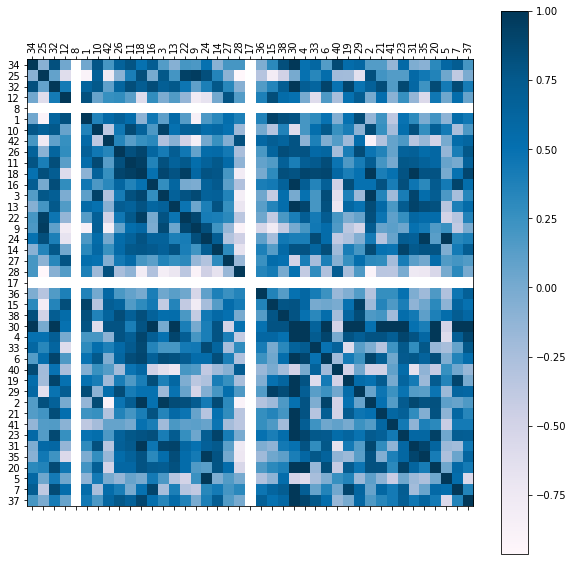

In [38]:

import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cmap=plt.cm.PuBu
cax = ax.matshow(matrix,cmap=cmap)
fig.colorbar(cax)

labels = [''] + location_ids
ax.set_xticklabels(labels,rotation=90)
ax.set_yticklabels(labels)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [46]:
### TODO
# Compute the correlation matrix
def get_correlation_matrix_daily(location_ids):
    outer_list=[]
    empty_days = pd.DataFrame(index=range(7))
    
    for first_loc in location_ids:
        inner_list=[]
        first_data = get_museum_daily(connection, first_loc)
        
        num_rows, num_cols = first_data.shape
        if num_rows <= 3:
            inner_list = [np.nan]*len(location_ids)
            outer_list.append(inner_list)
            continue
            
        first_interpolated = empty_days.merge(first_data, 'outer', right_on='entry_day', left_index=True)
        first = first_interpolated['entries'].tolist()
        
        for second_loc in location_ids:
            second_data = get_museum_daily(connection, second_loc)

            num_rows, num_cols = second_data.shape
            if num_rows <= 3:
                inner_list.append(np.nan)
                continue
            
            second_interpolated = empty_days.merge(second_data, 'outer', right_on='entry_day', left_index=True)
            second = second_interpolated['entries'].tolist()
            
            result = spearmanr(first, second, nan_policy='omit')
            inner_list.append(result.correlation)
        
        outer_list.append(inner_list)
    
    return outer_list
            
locations = get_active_firenze_locations(connection)
location_ids = locations['museum_id'].tolist()

matrix_daily = get_correlation_matrix_daily(location_ids)


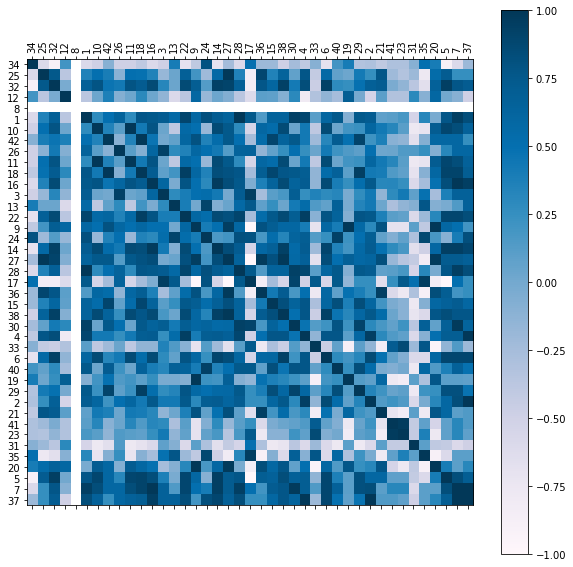

[34, 25, 32, 12, 8, 1, 10, 42, 26, 11, 18, 16, 3, 13, 22, 9, 24, 14, 27, 28, 17, 36, 15, 38, 30, 4, 33, 6, 40, 19, 29, 2, 21, 41, 23, 31, 35, 20, 5, 7, 37]


In [54]:

import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cmap=plt.cm.PuBu
cax = ax.matshow(matrix_daily,cmap=cmap)
fig.colorbar(cax)

labels = [''] + location_ids
ax.set_xticklabels(labels,rotation=90)
ax.set_yticklabels(labels)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
print(location_ids)

In [30]:
first = get_museum_hourly(connection, 9)

def plot_museum(data):
    data = [Bar(y=data['entries'], x=data['entry_hour'])]
    layout = go.Layout(
        title='Test',
        yaxis=dict(
            title='Entries',
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        ),
        xaxis=dict(
            title='Hour',
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)
    plot_url = py.iplot(fig, filename='correlation_test', sharing='private')
    return plot_url

plot_url = plot_museum(first)
plot_url

In [31]:
second = get_museum_hourly(connection, 25)
plot_url = plot_museum(second)
plot_url

In [43]:
#### Summary statistic plots
# import plotly.figure_factory as ff
# test = df3.groupby('user_id')['time_until_next_museum']
# data = [Bar(x = test.time_until_next_museum,
#                 y=test.user_id)]
# py.iplot(data, filename='time between entries', sharing='private')

In [ ]:
# df1 = df1.groupby('day_of_week', as_index=False)['total_people_in_museum'].sum()

# trace1 = Bar(
#     x= df1.day_of_week,
#     y= df1.total_people_in_museum
# )
# trace2 = Bar(
#     x= df2.day_of_week,
#     y= df2.total_people_in_museum
# )
# trace3 = Bar(
#     x= df3.day_of_week,
#     y= df3.total_people_in_museum
# )
# trace4 = Bar(
#     x= df4.day_of_week,
#     y= df4.total_people_in_museum
# )
# trace5 = Bar(
#     x= df5.day_of_week,
#     y= df5.total_people_in_museum
# )
# trace6 = Bar(
#     x= df6.day_of_week,
#     y= df6.total_people_in_museum
# )
# trace7 = Bar(
#     x= df7.day_of_week,
#     y= df7.total_people_in_museum
# )
# trace8 = Bar(
#     x= df8.day_of_week,
#     y= df8.total_people_in_museum,
#     name = ''
# )


# fig = tools.make_subplots(rows=8, cols=2)

# fig.append_trace(trace1, 1, 1)
# fig.append_trace(trace2, 2, 1)
# fig.append_trace(trace3, 3, 1)
# fig.append_trace(trace4, 4, 1)
# fig.append_trace(trace5, 1, 2)
# fig.append_trace(trace6, 2, 2)
# fig.append_trace(trace7, 3, 2)
# fig.append_trace(trace8, 4, 2)


# fig['layout'].update(height=800, width=900, title='Stacked subplots')
# py.iplot(fig, filename='stacked-subplots')

In [ ]:
#data2 = data[['museum_id', 'total_people_in_museum']]
#data.head()
data = data[['museum_id','total_people_in_museum']]
data2 = data.pivot("museum_id", "total_people_in_museum")
data2.head()

In [ ]:
df.T.corr(method='spearman')